In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor, DMatrix
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Change directory to the data directory
os.chdir("C:/Users/")

In [3]:
# Read data
X_train = pd.read_csv("train_X.csv", header="infer")
y_train = pd.read_csv("train_y.csv", header="infer")

X_test = pd.read_csv("test_X.csv", header="infer")
y_test = pd.read_csv("test_y.csv", header="infer")

## Preparing data

In [ ]:
# # Scale training data
ss = StandardScaler()
scaledXtrain = pd.DataFrame(ss.fit_transform(X_train))
scaledXtrain.columns = X_train.columns

# # Scale test data
scaledXtest = pd.DataFrame(ss.transform(X_test))
scaledXtest.columns = X_test.columns

X_train = scaledXtrain
X_test = scaledXtest

In [5]:
# Convert the dataset into the optimized data structure called Dmatrix
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

## Run XGBoost

In [ ]:
# Tuning hyperparameters
from sklearn.model_selection import GridSearchCV

xgb1 = XGBRegressor()

# Parameter grid search
parameters = {'objective':['reg:linear'],
              'learning_rate': [.01, 0.1, 0.2], 
              'max_depth': [3, 6, 10],
              'min_child_weight': [1, 3, 4],
              'silent': [0],
              'subsample': [0.5, 0.7, 1],
              'colsample_bytree': [0.5, 0.8, 1],
              'n_estimators': [10, 25, 50],
              'alpha': [0,10]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

In [ ]:
# View the optimal parameters and their model score
print(xgb_grid.best_params_)
print(xgb_grid.best_score_)

In [8]:
# Run XGB Regressor with the best parameters
xg_reg = xgb.XGBRegressor(**xgb_grid.best_params_)

In [ ]:
# Fit the regressor to the training set and make predictions on the test set
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

In [ ]:
# View the predictions
print(preds)

In [ ]:
# Compute the rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

In [ ]:
# View results
print("r^2: %f" % r2_score(y_test, preds))
print(" ")
print("Explained Variance Score: %f" % explained_variance_score(y_test, preds))
print(" ")
print("Accuracy score, test: %f" % xg_reg.score(X_test, y_test))
print(" ")
print("Accuracy score, train: %f" % xg_reg.score(X_train, y_train))

## Using k-fold cross-validation to calculate RMSE for training set

In [ ]:
# dtrain: the data from the Dmatrix
# params: hyperparameter dictionary
# nfolds: number of folds
# early_stopping_rounds: finishes training the model early if the hold-out metric ("rmse" in this case) doesn't improve 
#                        for a given number of rounds
# metrics: evaluation metrics to watch during CV (in this case, "rmse")
# as_pandas: return results in a pandas dataframe
# seed: for reproducibility of results

# Define the parameters as the best ones from the grid search
params = xgb_grid.best_params_

# Run 3-fold cross validation with the best parameters
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3, early_stopping_rounds=20,
                   metrics="rmse", as_pandas=True, seed=123)

# View some of the results
cv_results.tail()

In [ ]:
# The "test-rmse-mean" is the mean RMSE of the subsets of the training data that were held out for cross-validation
print((cv_results["test-rmse-mean"]).tail(1))

## Visualizing feature importance

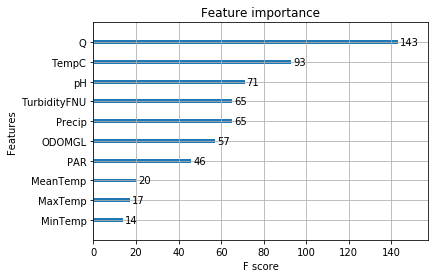

In [15]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()